# Preprocessing: PART III (_BL)

**INPUT: _filt.fif files**

1. Fixes the triggers for the _BL task
    - Reassign trigger numbers and give them names that make sense 
    - Adds missing start and end triggers for trials

2. Marks incomplete trials as bad

**OUTPUT: _filt_clean.fif file**

**Proceed preprocessing using 'clean_ICA.ipynb' file!**

In [127]:
import mne
import mne.io.fiff
import os
from utils import check_paths
import re
import copy
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib qt

Reassign values to the triggers

In [128]:
# This function assing names to the values (triggers) in EVENTS DICT corresponding to keys and replaces old trigger names with new ones in EVENTS ARRAY 
# INPUT: events tuple
# OUTPUT: tuple with renamed events
def rename_events_after_triggers(events: tuple) -> tuple:
    
    #check if there are values which overlap with keys
    above_10 = list(filter(lambda x: x >= 10, events[1].values()))

    if above_10:
        for i in above_10:
            new_value = ([key for key, value in events[1].items() if value == i])
            events[1][new_value[0]] = int(new_value[0])
            
            # Replace the values in the third column of the array
            events[0][:, 2] = np.where(events[0][:, 2] == i, int(new_value[0]), events[0][:, 2])
        
    new_events = copy.deepcopy(events)
    
    # Assing events the values corresponding to the keys names
    for key, value in new_events[1].items():
        new_value = int(re.search(r'\d+', key).group())
        new_events[1][key] = new_value

    # Create a mapping from the old event values to the new event values
    value_mapping = {events[1][key]: new_events[1][key] for key in events[1] if key in new_events[1]}

    # Replace the values in the third column of the events array
    for old_value, new_value in value_mapping.items():
        new_events[0][:, 2][new_events[0][:, 2] == old_value] = new_value

    return new_events



BASELINE TASK

100: launch of script
101: start instructions
102: break instructions
103: finish instructions 
10:	new trial
11:	prepare signal (white circle)
12:	inter stimulus interval 1
13:	go signal (green circle)
14:	inter stimulus interval 2
15:	KEY PRESS

In [129]:
# This function assings meaningful names to the keys in EVENTS DICT
# INPUT: events tuple
# OUTPUT: tuple with new EVENTS DICT keys

def make_sense(events: tuple, names_dict: dict) -> tuple:
    
    # Create an inverse mapping of main_dict
    inverse_dict = {v: k for k, v in names_dict.items()}

    # Replace keys in new_events with corresponding keys from main_dict
    replaced_keys_dict = {}
    for old_key, value in events[1].items():
        # Look up the corresponding new key using the value
        new_key = inverse_dict.get(value, old_key)  # Default to old_key if value not found in main_dict
        replaced_keys_dict[new_key] = value

    # Create a new tuple with the new dictionary
    new_events = (events[0], replaced_keys_dict)
    
    return new_events

SANITY CHECK for time distance btw start of the trial and ISI 2

In [130]:
# This function performs SANITY CHECK for time distance btw start of the trial and ISI 2: if mean significantly deviates from 250 - check the data
# INPUT: events array
# OUTPUT: list of time distances btw events

def time_diff_check(events_array: np.array) -> list:
    to_avg = []
    for i in range(len(events_array) - 1):
        if events_array[i, 2] == 14:
            if events_array[i+1, 2] == 10:
                # print(events_array[i+1, 0] - events_array[i, 0])
                if events_array[i+1, 0] - events_array[i, 0] < 1000:
                    to_avg.append(events_array[i+1, 0] - events_array[i, 0])

    print('Mean:', np.mean(to_avg))

    if int(np.mean(to_avg)) not in range(240,260):
        raise ValueError('Mean deviates from 250 - check the data!')

    return to_avg


Introduce start (10) and isi2 (14) of trial triggers if there are none

In [131]:
# This function adds start (10) and isi2 (14) of trial events, if they are missing
# INPUT: events array
# OUTPUT: updated events array

def add_start_and_end(events_array: np.array, events_ids: dict, to_avg: list) -> np.array:
    
    upd_events = []

    for i in range(len(events_array) - 1):

        # if there's no start
        if events_array[i, 2] == 14:
            if events_array[i+1, 2] != 10 and events_array[i+1, 2] not in range(100,104):
                print('trigger:', i,'- no start')
                
                # Add mean timing btw end (14) and start (10)
                new_event_time = events_array[i, 0] + int(np.mean(to_avg))

                # Create a new event with the trigger code 10
                new_event = [new_event_time, 0, events_ids['new_trial']]  # [time, 0, trigger code 8]

                # Append the new event to the modified_events array
                upd_events.append(new_event)
                print(new_event)
        
        # if there's no end
        elif events_array[i+1, 2] == 10:
            if events_array[i, 2] != 14 and events_array[i, 2] != 0 and events_array[i, 2] not in range(100,104):
                print('trigger:', i,'- no end')
                
                # Add mean timing btw end (14) and start (10)
                new_event_time = events_array[i+1, 0] - int(np.mean(to_avg))

                # Create a new event with the trigger code 14
                new_event = [new_event_time, 0, events_ids['isi2']]  # [time, 0, trigger code 9]

                # Append the new event to the modified_events array
                upd_events.append(new_event)
                print(new_event)

            # if no end for last trial
        elif events_array[i+1, 2] in range(102,104) and events_array[i, 2] != 14:
            
            # Subtract mean timing btw end (9) and start (8)
            new_event_time = events_array[i+1, 0] - 5

            # Create a new event with the trigger code 9
            new_event = [new_event_time, 0, events_ids['isi2']]  # [time, 0, trigger code 9]

            # Append the new event to the events_array array
            upd_events.append(new_event)
            # print(new_event)

    # Convert new_events list to a NumPy array
    upd_events = np.array(upd_events, dtype=int)

    # Combine the original events with the new events
    events_array = np.vstack((events_array, upd_events))

    # Sort the modified events by the time column (first column)
    events_array = events_array[np.argsort(events_array[:, 0])]

    # save final version of events tuple
    events_final = (events_array, events_ids)

    return events_final

    

CHECK EVENTS COUNTS

In [132]:
# This function counts number of events and checks if they match
# INPUT: events array
# OUTPUT: None or ValueError if events counts don't match

def check_events_counts(events_array: np.array) -> None:

    # Convert the column with trigger names to a pandas Series and get value counts
    value_counts = pd.Series(events_array[:,2]).value_counts()

    # Get counts for specific numbers (if they exist, otherwise return 0)
    count_10 = value_counts.get(10, 0) # start of trial
    count_11 = value_counts.get(11, 0) # prepare signal
    count_12 = value_counts.get(12, 0) # isi1
    count_13 = value_counts.get(13, 0) # go signal
    count_14 = value_counts.get(14, 0) # isi2
    count_15 = value_counts.get(15, 0) # key presses

    # Check if num of 10 equals num of 14
    if count_10 != count_14:
        raise ValueError(f"Count of 10 = {count_10} does not equal count of 14 = {count_14} !")

    print(f'Total number of trials: {count_10}')
    print(f'Total number of KEY PRESSES: {count_15}')

    # Check if num of 111 + num of 77 equals num of 8
    if count_11 != count_12 != count_13 != 120:
        print(f"Some events are missing:")
        print(f"Count of 11 = {count_11}")
        print(f"Count of 12 = {count_12}")
        print(f"Count of 13 = {count_13}")
        raise Warning(f"count_11 != count_12 != count_13 != 120 !")

    print("ALL GOOD: Events counts match!")

Marking the trials that do not contain [10, 11, 12, 13, 15, 14] pattern as BAD

In [133]:
# This function annotates trials that do not match the pattern [10, 11, 12, 13, 15, 14]
# INPUT: raw_filt fif file, events array
# OUTPUT: annotated raw_filt fif file

def annotate_bad_trials(raw_filt: mne.io.fiff.raw.Raw, events_array: np.array) -> mne.io.fiff.raw.Raw:

    # The correct trigger sequence for a normal trial
    correct_sequence = [10, 11, 12, 13, 15, 14]

    # Get the sampling frequency from the raw EEG data
    sfreq = raw_filt.info['sfreq']

    # Find indices of all trial starts (trigger 10)
    trial_start_indices = np.where(events_array[:, 2] == 10)[0]

    # List to store annotations for bad segments
    bad_segs = []

    # Iterate through each trial start index
    for start_idx in trial_start_indices:
        # Find the index of the corresponding '14' trigger (trial_end)
        trial_end_idx = np.where(events_array[start_idx:, 2] == 14)[0]
        
        if len(trial_end_idx) > 0:  # Make sure '14' trigger exists after '10'
            trial_end_idx = trial_end_idx[0] + start_idx  # Adjust relative to start_idx
            
            # Extract the potential trigger sequence starting from this trial start
            trigger_sequence = events_array[start_idx:trial_end_idx+1, 2]  # Include '14' in the sequence
            
            # Check if the extracted sequence matches the correct sequence
            if not np.array_equal(trigger_sequence, correct_sequence):
                # Mark this segment as bad from trigger 10 to trigger 14
                start_time = events_array[start_idx, 0] / sfreq  # Convert sample point to time (in seconds)
                end_time = events_array[trial_end_idx, 0] / sfreq  # Time of trigger 14
                
                # Append the bad segment as an annotation
                bad_segs.append((start_time, end_time - start_time, 'bad'))

    # Convert bad_segs list to MNE's Annotations format
    onsets, durations, descriptions = zip(*bad_segs)
    bad_annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)

    # Add the new annotations to the raw data
    raw_filt.set_annotations(bad_annotations)

    return raw_filt

_________________________

ANALYSIS START

In [134]:
# BL dictionary with events

bl_dict =  {'0, Impedance': 0,
            'script_start': 100,
            'start_instr': 101,
            'break_instr': 102,
            'finish_instr': 103,
            'new_trial': 10,
            'prepare': 11,
            'isi1': 12,
            'go': 13,
            'isi2': 14,
            'key_press': 15}


In [15]:
new_events

(array([[     0,      0,      0],
        [  5129,      0,     10],
        [  5159,      0,     11],
        ...,
        [148284,      0,     14],
        [148542,      0,    103],
        [151453,      0,      0]]),
 {'0, Impedance': 0,
  '10': 10,
  '102': 102,
  '103': 103,
  '11': 11,
  '12': 12,
  '13': 13,
  '14': 14,
  '15': 15})

In [31]:
os.listdir(subs_dir)

['s1_pac_sub01',
 's1_pac_sub05',
 's1_pac_sub07',
 's1_pac_sub10',
 's1_pac_sub11',
 's1_pac_sub19',
 's1_pac_sub22',
 's1_pac_sub24',
 's1_pac_sub26',
 's1_pac_sub28',
 's1_pac_sub29',
 's1_pac_sub32',
 's1_pac_sub33',
 's1_pac_sub38',
 's1_pac_sub52',
 's1_pac_sub66',
 's1_sub04_KS']

In [135]:
# Define the source directory and the destination directory
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y' # Y or G
subs_dir = os.path.join(eeg_data_dir, group)
task = '_BL' # '_BL' or '_MAIN'

for sub_name in ['s1_pac_sub66']: # os.listdir(subs_dir) OR ['s1_pac_sub00']

    filt_dir = os.path.join(subs_dir, sub_name, 'preproc', 'filt')
    eeg_data_path = os.path.join(filt_dir, f'{sub_name}{task}_filt.fif')
    raw_filt = mne.io.read_raw_fif(eeg_data_path, preload=True)
    events = mne.events_from_annotations(raw_filt)

    print(f'{sub_name}: PROCESSING TRIGGERS...')
    
    events = rename_events_after_triggers(events) # This function assing names to the values (triggers) in EVENTS DICT corresponding to keys 
                                                # and replaces old trigger names with new ones in EVENTS ARRAY 
    new_events = make_sense(events, bl_dict) # This function assings meaningful names to the keys in EVENTS DICT
    to_avg = time_diff_check(events_array=new_events[0]) # This function performs SANITY CHECK for time distance btw start of the trial and ISI 2:
                                                    # if mean significantly deviates from 250 - check the data
    events_final = add_start_and_end(events_array=new_events[0], events_ids=new_events[1], to_avg=to_avg) # This function adds start (10) and isi2 (14) of trial events, if they are missing

    # Check if number of events match
    try:
        check_events_counts(events_final[0]) # This function counts number of events and checks if they match
    except ValueError as e:
        print(f"Error: {e}")
    except Warning as w:
        print(f"Warning: {w}")

    # Save events tuple as a pickle file
    with open(os.path.join(filt_dir, f'{sub_name}{task}_events.pkl'), 'wb') as pickle_file:
        pickle.dump(events_final, pickle_file)
    print(f"{sub_name}: Events SAVED successfully!")


    raw_filt = annotate_bad_trials(raw_filt, events_final[0]) # This function annotates trials that do not match the pattern [10, 11, 12, 13, 15, 14]
    
    #! Check the raw data that contains annotations for bad segments
    # raw_filt.plot(events=events_final[0])

    # save annotated file
    raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt_events.fif'), overwrite=True)
    print(f'{sub_name}: Processing finished successfully - triggers recovered and bad trials marked!')

Opening raw data file D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub66\preproc\filt\s1_pac_sub66_BL_filt.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 0 ... 145402 =      0.000 ...   290.804 secs
Ready.
Reading 0 ... 145402  =      0.000 ...   290.804 secs...
Used Annotations descriptions: ['0, Impedance', '10', '101', '102', '103', '11', '12', '13', '14', '15']
s1_pac_sub66: PROCESSING TRIGGERS...
Mean: 250.140350877193
trigger: 217 - no start
[45441, 0, 10]
trigger: 384 - no end
[77966, 0, 14]
trigger: 593 - no end
[119558, 0, 14]
Total number of trials: 120
Total number of KEY PRESSES: 118
Some events are missing:
Count of 11 = 120
Count of 12 = 119
Count of 13 = 118
s1_pac_sub66: Events SAVED successfully!
Overwriting existing file.
Writing D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub66\preproc\filt\s1_pac_sub66_BL_filt_events.fif
Closing D:\BonoKat\research project\# study 1\eeg_data\set\

C:\Users\a1902989\AppData\Local\Temp\ipykernel_18944\1566385798.py:11: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub66\preproc\filt\s1_pac_sub66_BL_filt.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filt = mne.io.read_raw_fif(eeg_data_path, preload=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_18944\1566385798.py:43: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub66\preproc\filt\s1_pac_sub66_BL_filt_events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filt.save(os.path.join(filt_dir, f'{sub_name}{task}_filt_

[done]
s1_pac_sub66: Processing finished successfully - triggers recovered and bad trials marked!


____________

SANITY CHECKS

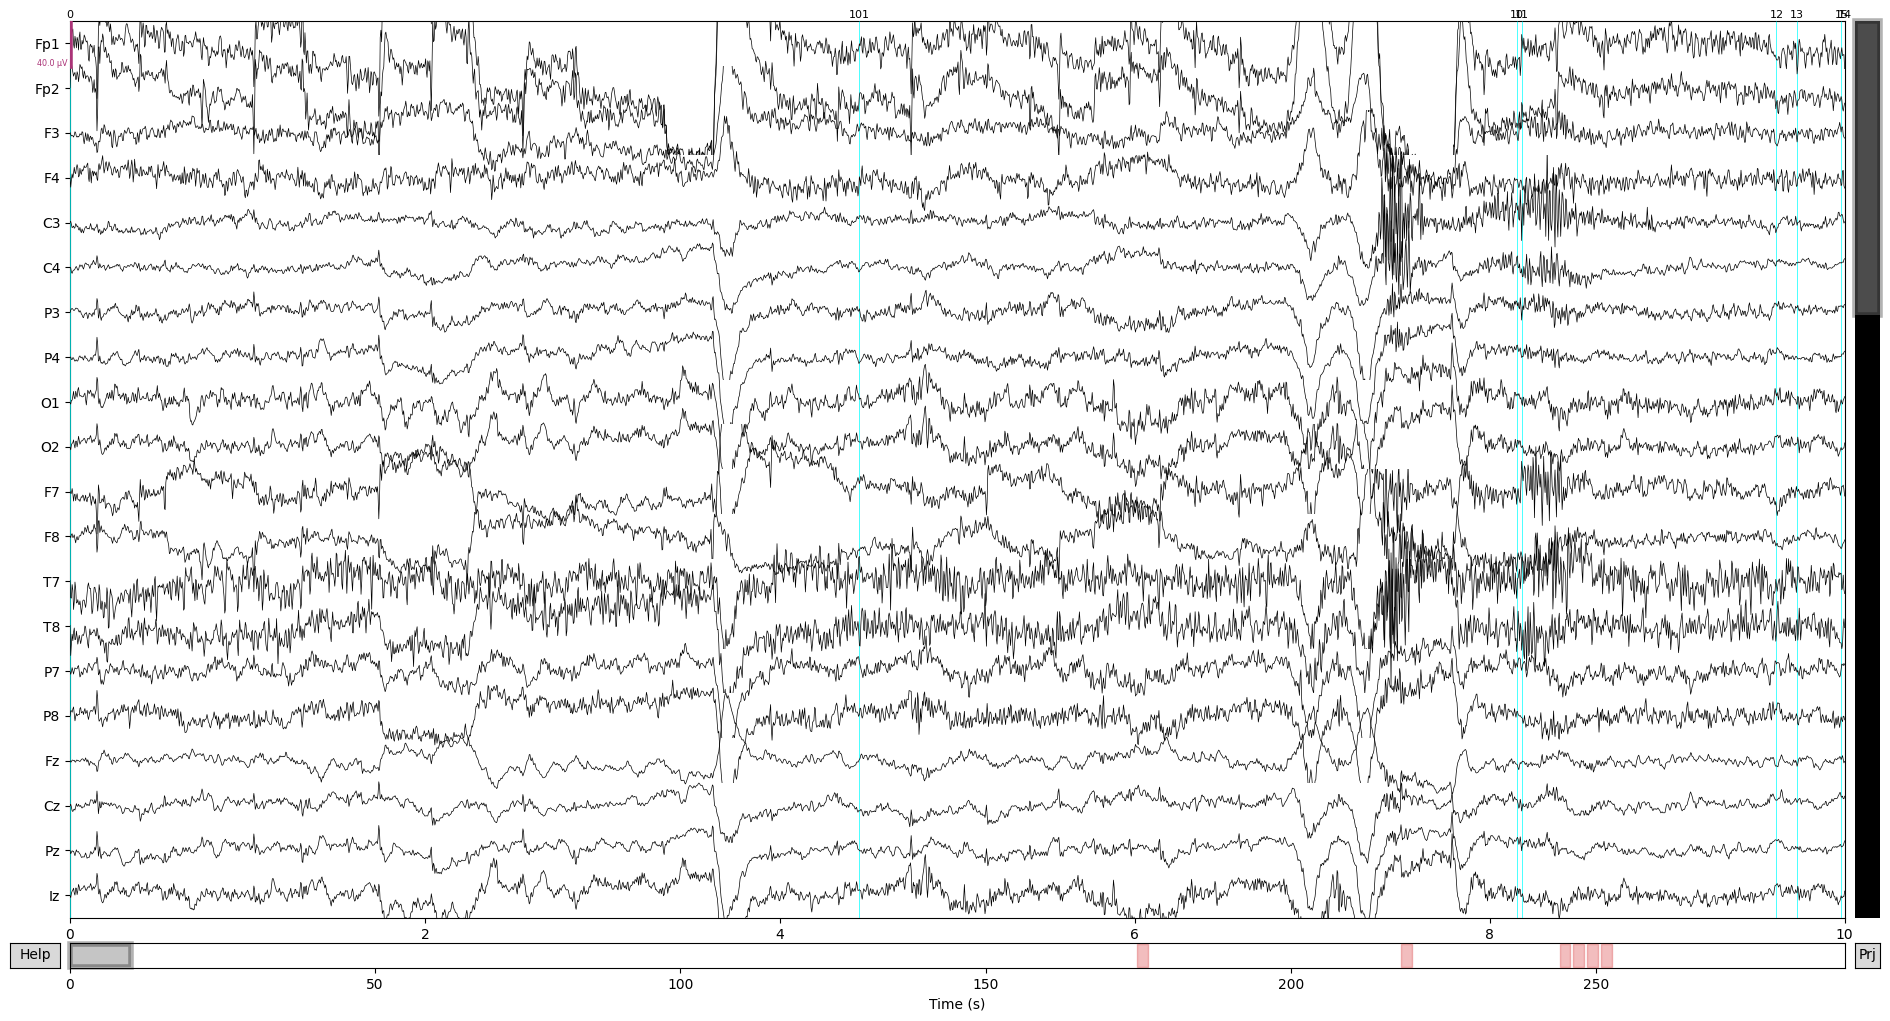

In [138]:
raw_filt.plot(events=events_final[0])

In [136]:
pd.Series(events_final[0][:, 2]).value_counts()

10     120
11     120
14     120
12     119
13     118
15     118
0        2
102      2
101      1
103      1
Name: count, dtype: int64

In [11]:
for i in events_final[0]:
    print(i)

[0 0 0]
[13580     0    10]
[13594     0    11]
[14311     0    12]
[14370     0    13]
[14515     0    15]
[14519     0    14]
[14770     0    10]
[14778     0    11]
[15494     0    12]
[15552     0    13]
[15709     0    15]
[15719     0    14]
[15970     0    10]
[15978     0    11]
[16694     0    12]
[16753     0    13]
[16827     0    15]
[16829     0    14]
[17079     0    10]
[17086     0    11]
[17802     0    12]
[17861     0    13]
[17940     0    15]
[17944     0    14]
[18195     0    10]
[18202     0    11]
[18919     0    12]
[18978     0    13]
[19108     0    15]
[19111     0    14]
[19362     0    10]
[19369     0    11]
[20086     0    12]
[20144     0    13]
[20263     0    15]
[20269     0    14]
[20520     0    10]
[20528     0    11]
[21244     0    12]
[21303     0    13]
[21448     0    15]
[21452     0    14]
[21703     0    10]
[21711     0    11]
[22428     0    12]
[22486     0    13]
[22615     0    15]
[22619     0    14]
[22869     0    10]
[22878     0